https://youtu.be/zpYq1gr1910

# Multiclass semantic segmentation


The dataset used in this video can be downloaded from the link below. This dataset can be used to train and test machine learning algorithms designed for multiclass semantic segmentation. Please read the Readme document for more information. 
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

To annotate your own images, please visit www.apeer.com

In [1]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import imageutils as iu
import glob
import cv2
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


ModuleNotFoundError: No module named 'seaborn'

## INPUT

In [3]:
projectPath= os.path.join("D:\\Data\\2023-01 Paestum")
xmlPath=os.path.join(projectPath,'IMG','cameras.xml')
# imagePath= os.path.join(projectPath,"Research",'Classification_test1','im_temp')
# maskPath = os.path.join(projectPath,"Research",'Classification_test1','mask_temp')
maskPath = os.path.join(projectPath,"Research",'Classification_test1','temp')

modelPath=os.path.join(projectPath,"Research",'Classification_test1',"UNET_segmentation")

In [5]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
# n_classes=12 #Number of classes for segmentation -> if this is biggger, we need to decrease the image size because else we need to compute 128x128x12 matrices (categorical means different channels per class)
num_images = 81  #Total 1600 available
skip=10

Get images


In [14]:
mask_names = glob.glob(maskPath+'/*mask.JPG')
mask =cv2.imread(mask_names[0])
print(mask)

[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [15]:
#get list of files
files=ut.get_list_of_files(ut.get_folder(xmlPath))
files=[f for f in files if f.endswith('.JPG')]
mask_names = glob.glob(maskPath+'/*mask.JPG')

#select images
image_dataset=[]
mask_dataset=[]
for f in files[0::skip]: 
    #read images   
    img=cv2.imread(f)    
    subimages,_=iu.subdivide_image(img,m=3,n=3)
    image_dataset.extend([np.array(tf.image.rgb_to_grayscale(tf.cast(tf.image.resize(im, (SIZE_X, SIZE_Y)), tf.float32)) / 255.0) for im in subimages])
    
    #read masks
    mask=next(cv2.imread(m) for m in mask_names if ut.get_filename(f) in ut.get_filename(m))
    submasks,_=iu.subdivide_image(mask,m=3,n=3)
    mask_dataset.extend([np.array(tf.cast(tf.image.resize(m, (SIZE_X, SIZE_Y)), tf.int8)) for m in submasks])

image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)[:,:,:,0]
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3) 
labels=np.unique(mask_dataset_encoded)
n_classes=len(labels)

In [5]:
#MB 
image_names = glob.glob(imagePath+'/*.JPG')
image_names.sort()
image_names_subset = image_names[0:num_images]
# RGB IMAGERY -> read all channels
images = [cv2.imread(image) for image in image_names_subset] # why only read first channel? this is for grayscale
# GRAYSCALE IMAGERY -> only read first channel
# images = [cv2.imread(image,0) for image in image_names_subset] 
# rescale images, turn into grayscale and set values to [0-1]
image_dataset=np.array([np.array(tf.image.rgb_to_grayscale(tf.cast(tf.image.resize(im, (SIZE_X, SIZE_Y)), tf.float32)) / 255.0) for im in images])

In [ ]:
# image_names = glob.glob(imagePath+'/*.JPG')
# image_names.sort()
# image_names_subset = image_names[0:num_images]
# images = [cv2.imread(image, 0) for image in image_names_subset] # why only read first channel? this is for grayscale
# image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 3)

In [30]:
# mask_names = glob.glob(maskPath+'/*.JPG')
# mask_names.sort()
# mask_names_subset = mask_names[0:num_images]
# masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
# mask_dataset = np.array(masks)

In [7]:
#MB 
mask_names = glob.glob(maskPath+'/*.JPG')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
# 3channel MASK (copied along third axis) -> read all channels else tf cannot resize -> keep only first first channel
masks = [cv2.imread(mask) for mask in mask_names_subset]
mask_dataset=np.array([np.array(tf.cast(tf.image.resize(m, (SIZE_X, SIZE_Y)), tf.int8)) for m in masks])[:,:,:,0]
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3) 
labels=np.unique(mask_dataset_encoded)
n_classes=len(labels)

In [16]:
print("Image data shape is: ", image_dataset.shape) # shape should be (n_image, 128,128,1)
print("Mask data shape is: ", mask_dataset_encoded.shape) # shape should be (n_image, 128,128,1)
print("Max pixel value in image is: ", image_dataset.max()) # -> max value should be 1 else normalize
print("Labels in the mask are : ", labels) # -> labels should be [0,1,2,3, ..] else remap
print("n_classes is : ", n_classes) 

Image data shape is:  (810, 128, 128, 1)
Mask data shape is:  (810, 128, 128, 1)
Max pixel value in image is:  0.99990004
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11]
n_classes is :  12


In [59]:
# #Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape -> not needed if masks are already [0,1,2,3, ...]
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# n, h, w = mask_dataset.shape  
# mask_dataset_reshaped = mask_dataset.reshape(-1,1)
# mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
# mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

# np.unique(mask_dataset_encoded)

In [60]:
# mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
# print(mask_dataset_encoded.shape)

In [ ]:
# #Normalize images
# image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

## Devide in training and testing samples

In [17]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
print(X_train.shape) # -> 80%
print(X_test.shape) # -> 20%

(648, 128, 128, 1)
(162, 128, 128, 1)


In [18]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes) # convert labels into channels
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train_cat.shape) # -> 80%
print(y_test_cat.shape) # -> 20%

(648, 128, 128, 12)
(162, 128, 128, 12)


## Building Unet by dividing encoder and decoder into blocks


In [19]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(128, 128, 1)


In [21]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

## TRAIN MODEL

In [22]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/50
41/41 [==============================] - 47s 832ms/step - loss: 1.8726 - accuracy: 0.4493 - val_loss: 1060.9690 - val_accuracy: 0.0483
Epoch 2/50
41/41 [==============================] - 29s 715ms/step - loss: 1.5171 - accuracy: 0.5044 - val_loss: 63.2276 - val_accuracy: 0.1859
Epoch 3/50
41/41 [==============================] - 29s 716ms/step - loss: 1.3946 - accuracy: 0.5241 - val_loss: 7.0869 - val_accuracy: 0.3454
Epoch 4/50
41/41 [==============================] - 29s 716ms/step - loss: 1.3156 - accuracy: 0.5380 - val_loss: 4.9768 - val_accuracy: 0.3479
Epoch 5/50
41/41 [==============================] - 30s 731ms/step - loss: 1.2594 - accuracy: 0.5601 - val_loss: 3.6849 - val_accuracy: 0.3170
Epoch 6/50
41/41 [==============================] - 30s 734ms/step - loss: 1.2173 - accuracy: 0.5690 - val_loss: 3.6393 - val_accuracy: 0.3446
Epoch 7/50
41/41 [==============================] - 29s 714ms/step - loss: 1.1833 - accuracy: 0.5837 - val_loss: 2.7506 - val_accuracy: 0.

save model

In [23]:
#Save the model for future use
model.save(modelPath)


INFO:tensorflow:Assets written to: D:\Data\2023-01 Paestum\Research\Classification_test1\UNET_segmentation\assets


INFO:tensorflow:Assets written to: D:\Data\2023-01 Paestum\Research\Classification_test1\UNET_segmentation\assets


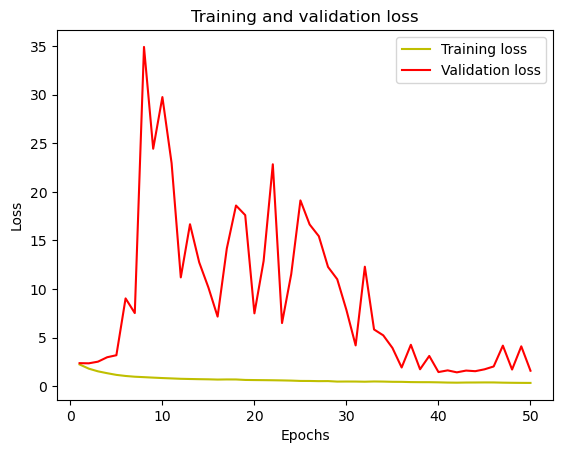

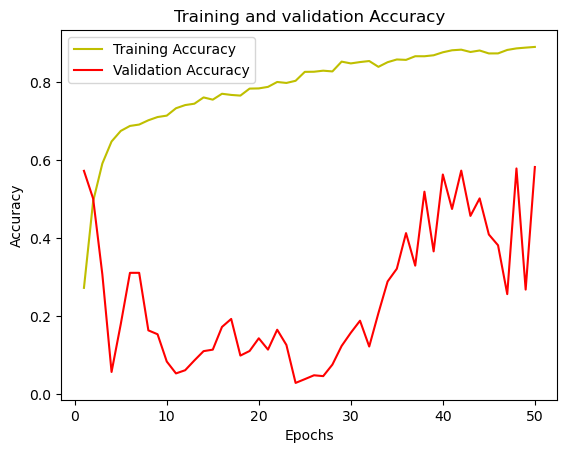

In [19]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

load prior model

In [ ]:

        #Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)

## PREDICT SOME DATA

In [24]:
y_pred=model.predict(X_test)

6/6 [==============================] - 5s 284ms/step


In [25]:
print(y_test[:,:,:,0].shape)
print(y_pred.shape)

(162, 128, 128)
(162, 128, 128, 12)


In [26]:
y_pred_argmax=np.argmax(y_pred, axis=3) # find max value in channels of the categorical and compress it back into 1 channel
y_pred_argmax.shape

(162, 128, 128)

report confusions

In [27]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.26660648


[[787458  27782    943      0  88403   3434    220      0     34   6432
       0      0]
 [ 36698 314976   7344      0  32681     34    186      0      4     73
       0      0]
 [ 11452  61376  58903      0  24738     23      5      0      0     28
       0      0]
 [   914    536     39      0    928     70     28      0     19    121
       0      0]
 [ 75693  91360   8341      0 540017  54758  23645      0  10210  21276
       0      0]
 [ 10490    453     87      0  25670  64804  24309      0   8224   6428
       0      0]
 [  6615    109     18      0  14674  22312  24841      0   2211   5411
       0      0]
 [   409      9      0      0    237    138     47      0    164    147
       0      0]
 [  5776    242      0      0   6370   8817   1558      0  22439   3642
       0      0]
 [ 24427    409      0      0  13412   4471   2499      0   8195  42811
       0      0]
 [   120      4      0      0      7      2      0      0      1     14
       0      0]
 [     1      0      

NameError: name 'sns' is not defined

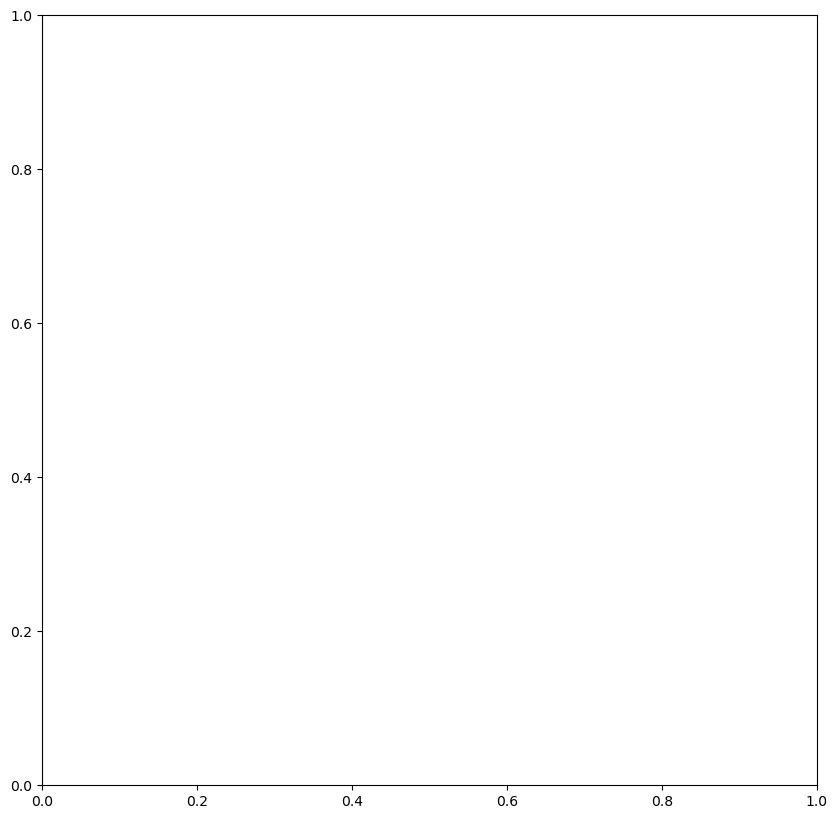

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(np.reshape(y_test[:,:,:,0],(-1,1)), np.reshape(y_pred_argmax,(-1,1)))
print(cf_matrix)
fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(cf_matrix, annot=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [35]:
sns.make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)


AttributeError: module 'seaborn' has no attribute 'make_confusion_matrix'

In [29]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values) # this is the confusion matrix

for l in labels:
    class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
    class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
    class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
    class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

    print("IoU for class1 is: ", class1_IoU)
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)



[[7.87458e+05 2.77820e+04 9.43000e+02 0.00000e+00 8.84030e+04 3.43400e+03
  2.20000e+02 0.00000e+00 3.40000e+01 6.43200e+03 0.00000e+00 0.00000e+00]
 [3.66980e+04 3.14976e+05 7.34400e+03 0.00000e+00 3.26810e+04 3.40000e+01
  1.86000e+02 0.00000e+00 4.00000e+00 7.30000e+01 0.00000e+00 0.00000e+00]
 [1.14520e+04 6.13760e+04 5.89030e+04 0.00000e+00 2.47380e+04 2.30000e+01
  5.00000e+00 0.00000e+00 0.00000e+00 2.80000e+01 0.00000e+00 0.00000e+00]
 [9.14000e+02 5.36000e+02 3.90000e+01 0.00000e+00 9.28000e+02 7.00000e+01
  2.80000e+01 0.00000e+00 1.90000e+01 1.21000e+02 0.00000e+00 0.00000e+00]
 [7.56930e+04 9.13600e+04 8.34100e+03 0.00000e+00 5.40017e+05 5.47580e+04
  2.36450e+04 0.00000e+00 1.02100e+04 2.12760e+04 0.00000e+00 0.00000e+00]
 [1.04900e+04 4.53000e+02 8.70000e+01 0.00000e+00 2.56700e+04 6.48040e+04
  2.43090e+04 0.00000e+00 8.22400e+03 6.42800e+03 0.00000e+00 0.00000e+00]
 [6.61500e+03 1.09000e+02 1.80000e+01 0.00000e+00 1.46740e+04 2.23120e+04
  2.48410e+04 0.00000e+00 2.2110

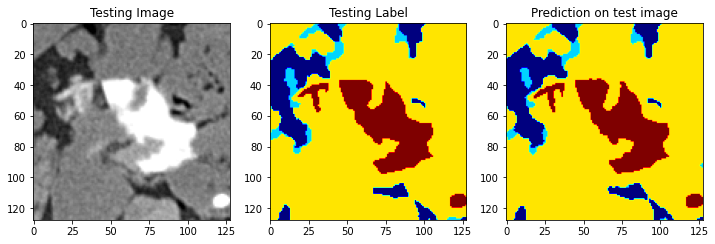

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()